In [1]:
from fastai.text import *
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [4]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-malyalam/classification


In [5]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-malyalam/classification')

In [6]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,headings,label
0,കൊച്ചി ചെരുപ്പ് വിതരണ കേന്ദ്രത്തിലെ തീപിടിത്തം...,business
1,ഈ​​​സ്റ്റേ​​​ണ്‍ ക​​​റി പൗ​​​ഡ​​​റി​​​ന് പു​​​...,business
2,ശ്രീശാന്തിന്റെ ആജീവനാന്ത വിലക്ക് പിന്‍വലിച്ചു,sports
3,റയല്‍ മാഡ്രിഡിനെ ഞെട്ടിച്ച യുവതാരം ബ്രസീല്‍ ടീ...,sports
4,"എനിക്ക് ശ്രീനിവാസന്‍ ആകേണ്ട, ലോഹിതദാസ് മതി : ക...",entertainment


In [7]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,headings,label
0,അന്താരാഷ്ട്ര ഇന്റര്‍നെറ്റ് സേവനം താല്‍ക്കാലികമ...,business
1,"മഞ്ഞ് ചതിച്ചാശാനേ!!!!, ഹാന്നോവറിന്റെ പ്രതീക്ഷക...",sports
2,"12 സീസണ്‍ എട്ടു ചാമ്ബ്യന്മാര്‍, പ്രവചിക്കാന്‍ ...",sports
3,\nമുംബൈ സിറ്റിയോടു തോറ്റിട്ടും യോഗ്യത നേടി ഗോവ...,sports
4,മദ്യപിച്ചെത്തിയ നടന്മാര്‍ തമ്മില്‍ കയ്യാങ്കളി;...,entertainment


In [8]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
business 1540
sports 1743
entertainment 1753


In [9]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
business 383
sports 446
entertainment 431


In [10]:
train_df['headings'][0]

'കൊച്ചി ചെരുപ്പ് വിതരണ കേന്ദ്രത്തിലെ തീപിടിത്തം; അന്വേഷണം തുടങ്ങി, അട്ടിമറി സാധ്യതയും പരിശോധിക്കുന്നു'

In [11]:
train_df.shape, valid_df.shape

((5036, 2), (1260, 2))

In [12]:
train_df[train_df['headings'].isnull()].shape, valid_df[valid_df['headings'].isnull()].shape

((0, 2), (0, 2))

In [13]:
label_cols = list(range(1,train_df.shape[1]))

In [14]:
print(label_cols)

[1]


In [16]:
id_to_col = list(train_df.columns)

In [17]:
col_to_id = {}
for i, col in enumerate(id_to_col):
    col_to_id[col] = i

In [18]:
class MalyalamTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/"../tokenizer/malyalam_lm.model"))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [19]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/"../tokenizer/malyalam_lm.model"))
itos = [sp.IdToPiece(int(i)) for i in range(10000)]

In [20]:
# 10,000 is the vocab size that we chose in sentencepiece
malyalam_vocab = Vocab(itos)

In [21]:
tokenizer = Tokenizer(tok_func=MalyalamTokenizer, lang='ml')

In [22]:
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [23]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=malyalam_vocab, bs=16)

In [24]:
data_lm.save()

In [25]:
data_lm.show_batch()

idx,text
0,▁ഡി ▁ന് ▁റെ ▁അ വാര ് ▁ ഡ് ▁പ ▁ രി ▁സ് ഥി ▁തി ▁സൗ ▁ഹ ൃ ▁ദ ▁പ്ര ▁വ ▁ര ് ▁ ത്ത ▁ന ▁ രീ ▁തി ▁കള ് ▁നടപ്പാക്ക ിയ ത ിനുള്ള ▁അംഗീകാര മായി ▁ x x bo s ▁ശ്രീശാന്ത ിന്റെ ▁ആ ജീവ ന ാന്ത ▁വിലക്ക ് ▁പി ന് ▁വലിച്ച ു ▁ x x bo s ▁റ യ ല് ▁മാഡ്രിഡ ിനെ ▁ഞ െ ട്ട ിച്ച ▁യുവ താര ം
1,"ങ്ങള ് ▁ക്ല ബ് ▁വിട ാന ൊരു ങ്ങ ുന്നു ; ▁റ യ ല് ▁പ്രതിസന്ധി യിലേക്ക് ▁ x x bo s ▁കോ ലി ക്ക് ▁വീ ണ്ടു മ ൊരു ▁റെ ക്കോ ര ് ▁ ഡ് , ▁ഇത് തവണ ▁എ ബി ഡി യെ ▁കടത്ത ി വെ ട്ടി <unk> ▁അ വി ശ്വ സ നീയ ▁നേട്ട ം , ▁സച്ചിന ും ▁പിന്ന ില ് ▁ x x bo s ▁ചരിത്രം ▁ആ വര ് ▁ ത്തി ക്കു"
2,"▁പ്രവചന ം ▁ x x bo s ▁താ ന് ▁കണ്ട ▁ഏറ്റവും ▁മികച്ച ▁മലയാള ▁സിനിമ ▁സു ഡ ാനി ▁ഫ്ര ം ▁നൈജീരിയ യാണെന്ന് ▁ഫഹദ് ▁ x x bo s ▁ഡ ല് ▁ഹി ▁ക്യാ പി റ്റ ല് ▁സ് ▁ഉപ ദ േ ഷ്ട ാവ ായി ▁സൗര വ് ▁ഗ ാംഗ ു ലി ▁ x x bo s ▁ചുണ്ട ില ് ▁എ രിയ ുന്ന ▁സി ഗര റ്റ് , ▁തീ ക്ഷണ മായ ▁നോട്ട ം ; ▁' ഇ"
3,s ▁ഫോ ബ് ▁സ് ▁ധന ിക രുടെ ▁പട്ടിക ; ▁മലയാളി കളില ് ▁ഒന്ന ാ മ ന് ▁എം ▁എ ▁യൂ സു ഫ ലി ▁തന്നെ ▁ x x bo s ▁റി ല യ ന് ▁സ് ▁ജി യോ യുടെ ▁പേരില ് ▁രാജ്യ വ്യാപക മായി ▁മൊ ബൈ ല് ▁ട വര ് ▁കുംഭ കൊ ണം ; ▁ശക്തമായ ▁നിയമ നടപടികള ുമായി ▁ക മ ് ബ നി ▁ x x bo s ▁തെരഞ്ഞെടുപ്പി ന് ▁മു ന് ▁പ
4,▁പ്രതി കാര ത്തെക്കുറിച്ച് ▁ചിത്ര ▁ x x bo s ▁നാല് ▁മാസ ങ്ങള ് ▁ ക്ക് ▁ശേഷം ▁പാര ് ▁വ തി ▁വീണ്ടും ▁സോ ഷ്യ ല് ▁മീഡിയ യിലേക്ക് ▁ x x bo s ▁ലോകകപ്പ ് ▁ടീമ ില ് ▁ഇട ം ▁നേട ുകയാണ് ▁തന്റെ ▁ഏറ്റവും ▁വലിയ ▁മോഹ ം ; ▁ഓ സ് ▁ട്ര േലിയ ന് ▁താര ം ▁ x x bo s ▁ഏകദിന ▁കരി യ റി ല് ▁മറ്റൊരു ▁നാ ഴി ക ക്കല്ല ിന രി


In [26]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [27]:
# Loading the pretrained language model on malyalam wikipedia
learn.load('/home/gaurav/PycharmProjects/nlp-for-malyalam/language-model/MalyalamDataset/models/third_ml_lm', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5036 items)
x: LMTextList
▁ x x bo s ▁കൊച്ചി ▁ചെ രു പ്പ് ▁വിതരണ ▁കേന്ദ്ര ത്തിലെ ▁തീ പിടി ത്ത ം ; ▁അന്വേഷണ ം ▁തുടങ്ങി , ▁അട്ടിമറി ▁സാധ്യത യും ▁പരിശോധിക്ക ുന്നു,▁ x x bo s ▁ഈ ▁സ്റ്റ േ ▁ ണ് ▁ക ▁റി ▁പൗ ▁ഡ ▁റി ▁ന് ▁പു ▁ര ▁സ്ക ാ ▁ര ം ; ▁സം ▁ സ്ഥ ാ ▁ന ▁മ ▁ലി ▁നീ ▁ക ▁ര ▁ ണ ▁നി ▁യ ▁ന് ത്ര ▁ ണ ▁ബോ ▁ര ് ▁ഡി ▁ന് ▁റെ ▁അ വാര ് ▁ ഡ് ▁പ ▁ രി ▁സ് ഥി ▁തി ▁സൗ ▁ഹ ൃ ▁ദ ▁പ്ര ▁വ ▁ര ് ▁ ത്ത ▁ന ▁ രീ ▁തി ▁കള ് ▁നടപ്പാക്ക ിയ ത ിനുള്ള ▁അംഗീകാര മായി,▁ x x bo s ▁ശ്രീശാന്ത ിന്റെ ▁ആ ജീവ ന ാന്ത ▁വിലക്ക ് ▁പി ന് ▁വലിച്ച ു,▁ x x bo s ▁റ യ ല് ▁മാഡ്രിഡ ിനെ ▁ഞ െ ട്ട ിച്ച ▁യുവ താര ം ▁ബ്രസീല ് ▁ടീമ ില ്,▁ x x bo s ▁എനിക്ക് ▁ശ്രീനിവാസ ന് ▁ആക േണ്ട , ▁ലോഹ ിത ദാസ് ▁മതി ▁: ▁കാരണം ▁തുറന്നു ▁പറഞ്ഞു ▁ശ്യാം ▁പു ഷ് കര ന്
y: LMLabelList
,,,,
Path: /home/gaurav/PycharmProjects/nlp-for-malyalam/classification;

Valid: LabelList (1260 items)
x: LMTextList
▁ x x bo s ▁അന്താരാഷ്ട്ര ▁ഇ ന്റ ര ് ▁നെറ്റ് ▁സേവനം ▁താ ല് ▁ ക്കാല ിക മായി ▁നിര ് ▁ ത്ത ലാ ക്കും ; ▁സൈ ബ ര ് ▁പ്രതിരോധ ത്തിന്റെ ▁ഭ

In [28]:
# Fine tuning the prtrained LM on current dataset

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


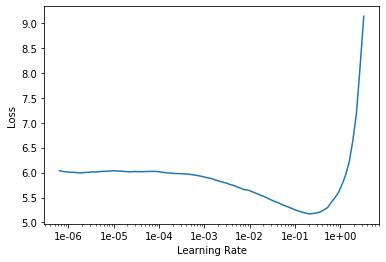

In [30]:
learn.recorder.plot()

In [31]:
learn.freeze()

In [32]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.363463,3.974632,0.376434,00:09


In [33]:
learn.unfreeze()

In [34]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.760584,3.642399,0.413934,00:11
1,3.386792,3.324242,0.453842,00:11
2,3.036842,3.172777,0.475406,00:11
3,2.796628,3.115433,0.485308,00:11
4,2.679175,3.108219,0.486688,00:11


In [35]:
learn.predict('മലയാള ികളായ ▁വിമാന യാത്ര ക്കാര',n_words=10)

'മലയാള ികളായ ▁വിമാന യാത്ര ക്കാര ് വിള ിക്കുന്നു ▁ x x bo s ▁ഷെ ഫ്'

In [36]:
learn.save_encoder('fine_tuned_enc')

In [37]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=malyalam_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [38]:
data_clas.show_batch()

text,target
▁ x x bo s ▁ശ ▁ബ ▁ രി ▁മ ▁ല ▁വി ▁ക ▁സ ▁ന ത്തിനായി ▁സ ▁ര ് ▁ ക്കാ ▁ര ് ▁നി ▁യ ▁ന് ത്ര ▁ ണ ▁ ത്തി ▁ല ് ▁പ്ര ▁ ത് യേ ▁ക ▁ക ▁മ ് ബ ▁നി ▁ര ൂ ▁പീ ▁ക ▁ രി ▁ ക്കാ ▁ന് ▁തീ ▁ രു ▁മാ ▁ന ം ; ▁നടപടി ▁തീ ▁ x x re p ▁5 ▁ര ് ▁,business
▁ x x bo s ▁ജെ ▁ റ്റ് ▁എ ▁യ ▁ര ് ▁വേ സി ▁നെ ▁ര ▁ ക്ഷി ▁ ക്കാ ▁നു ▁ ള്ള ▁ശ്ര ▁മ ▁ ങ്ങ ▁ ള ് ▁ ക്കു ▁വീ ▁ ണ്ടു ം ▁ത ▁ട ▁സം ; ▁കു ▁ടി ▁ശി ▁ക യെ തു ▁ട ▁ര ് ▁ ന്ന് ▁ഒ ▁ന് ▁പ ▁തു ▁വി ▁മാ ▁ന ▁ ങ്ങ ▁ ള ് ▁പാ ▁ ട്ട ▁ ക്ക മ ്,business
▁ x x bo s ▁ഇതു പോ ല ൊരു ▁റ ണ് ▁ചേ സ് ▁മൊ ഹാ ലി ▁കണ്ട ിട്ടില്ല ; ▁ടീം ▁ഇന്ത്യയുടെ ▁റ ണ് ▁മല ▁ 43 ▁പന്ത ില ് ▁ഓടി ക്ക യ റി ▁ആ ഷ്ട ണ് ▁ട േണ ര ് ▁ഓ സീ സിന്റെ ▁വിജയ ക്കൊ ടി ▁ഉയര ് ▁ ത്തിയ പ്പോ ള ് ▁തല കു ന ിച്ച് ▁കോ ഹ് ലി യും ▁കൂട്ട ു കാര ും ; ▁നാലു വി ക്ക റ്റ്,sports
▁ x x bo s ▁ഐ എസ് ▁എ ല് ▁സെമി യിലെ ▁രണ്ടാം ▁പാദ ത്തില ് ▁ഒരു ▁ഗോള ിന് ▁തോ റ്റ ിട്ടും ▁എഫ് ▁സി ▁ഗോവ ▁ഫൈനല ില ് ▁ ; ▁തു ണ യായ ത് ▁ആദ്യ ▁മത്സര ത്തിലെ ▁കൂ റ്റ ന് ▁ <unk> 5 -1 ) ▁ജയ ം ; ▁നാ ട്ടി ല് ▁നടക്കുന്ന ▁ഫൈനല ിന് ▁യോഗ്യത ▁നേട ാതെ ▁മുംബൈ യുടെ ▁മ ടക്കം ; ▁പുതിയ ▁കിരീട ാവകാശ ി കളെ ▁തേടി യുള്ള ▁കലാശ പ്പോ,sports
▁ x x bo s ▁ഐ എസ് ▁എ ല് ▁സെമി യിലെ ▁രണ്ടാം ▁പാദ ത്തില ് ▁ഒരു ▁ഗോള ിന് ▁തോ റ്റ ിട്ടും ▁എഫ് ▁സി ▁ഗോവ ▁ഫൈനല ില ് ▁ ; ▁തു ണ യായ ത് ▁ആദ്യ ▁മത്സര ത്തിലെ ▁കൂ റ്റ ന് ▁ <unk> 5 -1 ) ▁ജയ ം ; ▁നാ ട്ടി ല് ▁നടക്കുന്ന ▁ഫൈനല ിന് ▁യോഗ്യത ▁നേട ാതെ ▁മുംബൈ യുടെ ▁മ ടക്കം ; ▁പുതിയ ▁കിരീട ാവകാശ ി കളെ ▁തേടി യുള്ള ▁കലാശ പ്പോ,sports


In [39]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [40]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [41]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5036 items)
x: TextList
▁ x x bo s ▁കൊച്ചി ▁ചെ രു പ്പ് ▁വിതരണ ▁കേന്ദ്ര ത്തിലെ ▁തീ പിടി ത്ത ം ; ▁അന്വേഷണ ം ▁തുടങ്ങി , ▁അട്ടിമറി ▁സാധ്യത യും ▁പരിശോധിക്ക ുന്നു,▁ x x bo s ▁ഈ ▁സ്റ്റ േ ▁ ണ് ▁ക ▁റി ▁പൗ ▁ഡ ▁റി ▁ന് ▁പു ▁ര ▁സ്ക ാ ▁ര ം ; ▁സം ▁ സ്ഥ ാ ▁ന ▁മ ▁ലി ▁നീ ▁ക ▁ര ▁ ണ ▁നി ▁യ ▁ന് ത്ര ▁ ണ ▁ബോ ▁ര ് ▁ഡി ▁ന് ▁റെ ▁അ വാര ് ▁ ഡ് ▁പ ▁ രി ▁സ് ഥി ▁തി ▁സൗ ▁ഹ ൃ ▁ദ ▁പ്ര ▁വ ▁ര ് ▁ ത്ത ▁ന ▁ രീ ▁തി ▁കള ് ▁നടപ്പാക്ക ിയ ത ിനുള്ള ▁അംഗീകാര മായി,▁ x x bo s ▁ശ്രീശാന്ത ിന്റെ ▁ആ ജീവ ന ാന്ത ▁വിലക്ക ് ▁പി ന് ▁വലിച്ച ു,▁ x x bo s ▁റ യ ല് ▁മാഡ്രിഡ ിനെ ▁ഞ െ ട്ട ിച്ച ▁യുവ താര ം ▁ബ്രസീല ് ▁ടീമ ില ്,▁ x x bo s ▁എനിക്ക് ▁ശ്രീനിവാസ ന് ▁ആക േണ്ട , ▁ലോഹ ിത ദാസ് ▁മതി ▁: ▁കാരണം ▁തുറന്നു ▁പറഞ്ഞു ▁ശ്യാം ▁പു ഷ് കര ന്
y: CategoryList
business,business,sports,sports,entertainment
Path: /home/gaurav/PycharmProjects/nlp-for-malyalam/classification;

Valid: LabelList (1260 items)
x: TextList
▁ x x bo s ▁അന്താരാഷ്ട്ര ▁ഇ ന്റ ര ് ▁നെറ്റ് ▁സേവനം ▁താ ല് ▁ ക്കാല ിക മായി ▁നിര ് ▁ ത്ത ലാ ക്കു

In [42]:
learn.freeze()

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


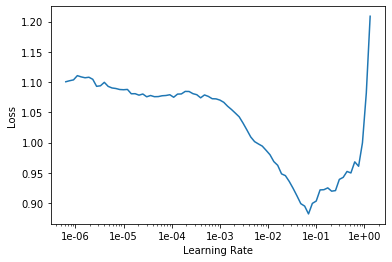

In [44]:
learn.recorder.plot()

In [45]:
learn.loss_func.func

CrossEntropyLoss()

In [46]:
kappa = KappaScore()

In [47]:
learn.metrics = [kappa, accuracy]

In [48]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.508436,0.399190,0.782978,0.855556,00:08


In [49]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.317450,0.255459,0.868802,0.912698,00:09


In [50]:
learn.save('second-full')

In [51]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.197420,0.219929,0.893986,0.929365,00:14
1,0.141480,0.223078,0.898830,0.932540,00:14
2,0.100687,0.201666,0.905913,0.937302,00:14
3,0.069161,0.193449,0.909454,0.939683,00:15
4,0.038464,0.193119,0.915401,0.943651,00:14


Better model found at epoch 0 with accuracy value: 0.9293650984764099.
Better model found at epoch 1 with accuracy value: 0.932539701461792.
Better model found at epoch 2 with accuracy value: 0.9373015761375427.
Better model found at epoch 3 with accuracy value: 0.9396825432777405.
Better model found at epoch 4 with accuracy value: 0.9436507821083069.


In [52]:
learn.predict('ന്യൂഡല്‍ഹി: വിക്കറ്റിന് പിറകിൽ എം.എസ്. ധോനിയുടെ പിന്‍ഗാമിയായി സെലക്ടര്‍മാര്‍ ഉയര്‍ത്തിക്കാട്ടിയ താരമായിരുന്നു ഋഷഭ് ')

(Category sports, tensor(2), tensor([0.0042, 0.0322, 0.9636]))

In [53]:
learn.predict("കോഴിക്കോട്: ഏറെ പ്രതീക്ഷയോടെ ഐ ലീഗ് സീസണിന് ഇറങ്ങിയ ഗോകുലം കേരള എഫ്.സിക്ക് ഒടുവില്‍ നിരാശയായിരുന്നു")

(Category sports, tensor(2), tensor([0.0302, 0.0074, 0.9623]))

In [54]:
learn.predict("ഒരൊറ്റ സീന്‍. ഒരൊറ്റ ഡയലോഗ്. ഇരിങ്ങാലക്കുടയ്ക്കപ്പുറത്ത് ഏറെയൊന്നും അറിയപ്പെടാതിരുന്ന ആളൂര്‍")

(Category entertainment, tensor(1), tensor([0.0039, 0.8278, 0.1683]))

In [55]:
learn.predict("ബിഗ് ബോസ് എന്ന റിയാലിറ്റി ഷോയിലൂടെ മലയാളികളുടെ പ്രിയങ്കരനായി മാറിയ ടെലിവിഷന്‍ താരമാണ് ഷിയാസ് ")

(Category entertainment, tensor(1), tensor([0.0271, 0.9367, 0.0362]))

In [56]:
learn.predict("ന്യൂഡല്‍ഹി: തിരഞ്ഞെടുപ്പിന് മാസങ്ങൾമാത്രം ശേഷിക്കെ മോദി സർക്കാരിന്റെ അഞ്ചുവർഷത്തെ നേട്ടങ്ങൾ")

(Category business, tensor(0), tensor([0.9876, 0.0059, 0.0065]))